**Install Required Libraries**

In [1]:
!pip install requests pandas google-cloud-bigquery


In [2]:
import requests
import pandas as pd
from datetime import datetime


In [3]:
#Creating a Simple Data Collector Agent...

def data_collector_agent(country="India"):
    url = f"https://disease.sh/v3/covid-19/countries/{country}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame([{
            "country": data["country"],
            "cases": data["cases"],
            "todayCases": data["todayCases"],
            "deaths": data["deaths"],
            "todayDeaths": data["todayDeaths"],
            "recovered": data["recovered"],
            "active": data["active"],
            "updated": datetime.fromtimestamp(data["updated"]/1000)
        }])
        print("Data collected successfully!")
        return df
    else:
        print("Failed to fetch data.")
        return None


In [4]:
# Run the Agent..

df = data_collector_agent("India")
df


Data collected successfully!


,country,cases,todayCases,deaths,todayDeaths,recovered,active,updated
0,India,45035393,0,533570,0,0,44501823,2025-06-23 18:14:36.403


In [5]:
# Data cleaning..
def data_cleaner_agent(df):
    # 1. Drop unnecessary columns
    if 'recovered' in df.columns:
        df = df.drop(columns=['recovered'])

    # 2. Handle missing values (if any)
    df = df.fillna(0)

    # 3. Ensure correct data types
    df['cases'] = df['cases'].astype(int)
    df['todayCases'] = df['todayCases'].astype(int)
    df['deaths'] = df['deaths'].astype(int)
    df['todayDeaths'] = df['todayDeaths'].astype(int)
    df['active'] = df['active'].astype(int)
    df['updated'] = pd.to_datetime(df['updated'])

    print("Data cleaned successfully!")
    return df


In [6]:
# Running the Cleaner Agent..

clean_df = data_cleaner_agent(df)
clean_df


Data cleaned successfully!


,country,cases,todayCases,deaths,todayDeaths,active,updated
0,India,45035393,0,533570,0,44501823,2025-06-23 18:14:36.403


In [7]:
# TrendAnalyzerAgent.......

def trend_analyzer_agent(df):
    trend_summary = []

    for index, row in df.iterrows():
        trend = "Stable"

        if row["todayCases"] > 10000:
            trend = "🚨 Major Spike Detected"
        elif row["todayCases"] > 1000:
            trend = "⚠️ Moderate Spike Detected"
        elif row["todayCases"] > 0:
            trend = "🔍 Slight Increase Observed"
        elif row["todayCases"] == 0:
            trend = "✅ No new cases today"

        summary = {
            "country": row["country"],
            "date": row["updated"].date(),
            "total_cases": row["cases"],
            "today_cases": row["todayCases"],
            "status": trend
        }
        trend_summary.append(summary)

    result_df = pd.DataFrame(trend_summary)
    print("Trend analysis complete.")
    return result_df



In [8]:
# Run the Agent:....

trend_df = trend_analyzer_agent(clean_df)
trend_df


Trend analysis complete.


,country,date,total_cases,today_cases,status
0,India,2025-06-23,45035393,0,✅ No new cases today


In [9]:
# Next Agent: InsightGeneratorAgent.....
def insight_generator_agent(trend_df):
    insights = []

    for index, row in trend_df.iterrows():
        message = (
            f"As of {row['date']}, {row['country']} reported "
            f"{row['today_cases']} new COVID-19 case(s). "
            f"The total number of confirmed cases is {row['total_cases']}. "
            f"Status: {row['status']}."
        )
        insights.append(message)

    print("Insight generation complete.")
    return insights



In [10]:
# Running the agent....
insight_texts = insight_generator_agent(trend_df)

# Display insights
for insight in insight_texts:
    print("📝", insight)


Insight generation complete.
📝 As of 2025-06-23, India reported 0 new COVID-19 case(s). The total number of confirmed cases is 45035393. Status: ✅ No new cases today.


In [15]:
import matplotlib.pyplot as plt

def dashboard_agent_colab(trend_df):
    today_cases = trend_df['today_cases'].iloc[0]
    country = trend_df['country'].iloc[0]
    date = trend_df['date'].iloc[0]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_facecolor('#f9f9f9')  # light background

    bars = ax.bar([country], [today_cases], color='lightgreen', edgecolor='black')

    ax.set_title(f"Today's COVID-19 Cases by Country ({date})")
    ax.set_ylabel("New Cases")
    ax.set_xlabel("Country")

    # Adjust y-limit for better visual feedback
    upper_limit = 10 if today_cases == 0 else today_cases + 10
    plt.ylim(0, upper_limit)

    # Show bar label slightly above base even if value is 0
    for bar in bars:
        yval = bar.get_height()
        position = 0.5 if yval == 0 else yval + 0.5
        ax.text(bar.get_x() + bar.get_width() / 2, position, str(yval), ha='center', va='bottom')

    # Optional: Add text for "No data" if everything is zero
    if today_cases == 0:
        ax.text(0.5, 5, "✅ No new COVID-19 cases today", fontsize=10, ha='center', va='center', color='green')

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-15-1444442239.py:31: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


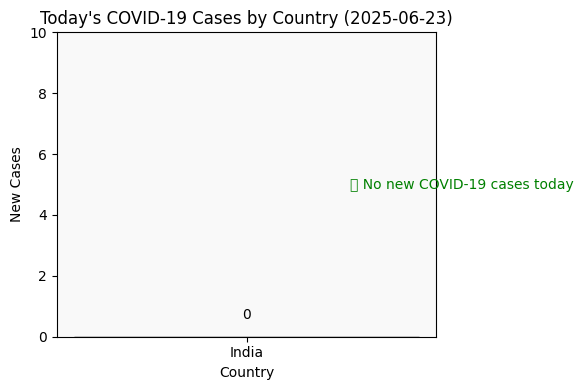

In [16]:
dashboard_agent_colab(trend_df)


In [17]:
from google.colab import auth
from google.cloud import bigquery

# Step 1: Authenticate
auth.authenticate_user()

# Step 2: Set your project ID and dataset/table
project_id = "cellular-unity-460313-b7"         # ✅ use your actual project ID
dataset_id = "health_insights"                  # ✅ dataset you created
table_id = "daily_covid_data"                   # ✅ new table name

# Step 3: Create full table reference
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Step 4: Initialize BigQuery client
client = bigquery.Client(project=project_id)

# Step 5: Upload DataFrame (clean_df) to BigQuery
job = client.load_table_from_dataframe(clean_df, table_ref)
job.result()  # Wait for job to complete

print(f"✅ Data uploaded successfully to {table_ref}")


✅ Data uploaded successfully to cellular-unity-460313-b7.health_insights.daily_covid_data
